In [1]:
import pandas as pd
import sklearn

In [2]:
leaflet_data = pd.read_csv('./leaflets_data_2019.csv')

In [3]:
leaflet_data.head()

,leaflet_ID,URL,image_urls,local_images,Election:,Party:,Constituency:,Mentions:,Issues Covered:,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,31182,https://www.openelections.co.uk/leaflets/31182/,['https://cdn.openelections.co.uk/uploads/2020...,"['leaflet_images/31182/17083_1-1024x768.jpg', ...",2019 General Election,Liberal Democrats,Cambridge,"Other party/leader/candidate, Party leader",NaN,NaN,NaN,NaN
1,31193,https://www.openelections.co.uk/leaflets/31193/,['https://cdn.openelections.co.uk/uploads/2020...,"['leaflet_images/31193/17087_1-718x1024.jpg', ...",2019 General Election,Conservative Party,South Holland and The Deepings,Candidate,"Brexit/Europe, Education, Environment, Health",NaN,NaN,NaN
2,31210,https://www.openelections.co.uk/leaflets/31210/,['https://cdn.openelections.co.uk/uploads/2020...,['leaflet_images/31210/17091_1-716x1024.jpg'],2019 General Election,Liberal Democrats,South Cambridgeshire,"Other party/leader/candidate, Party leader","Economy, Education, Environment, Health",NaN,NaN,NaN
3,31222,https://www.openelections.co.uk/leaflets/31222/,['https://cdn.openelections.co.uk/uploads/2020...,"['leaflet_images/31222/17096_1-768x1024.jpg', ...",2019 General Election,Labour Party,Aberconwy,Other party/leader/candidate,"Brexit/Europe, Economy, Environment, Health, S...",NaN,NaN,NaN
4,31242,https://www.openelections.co.uk/leaflets/31242/,['https://cdn.openelections.co.uk/uploads/2020...,['leaflet_images/31242/17104_1-1024x354.jpg'],2019 General Election,Labour Party,Stoke-on-Trent Central,"Candidate, Other party/leader/candidate, Tacti...","Economy, Education, Environment, Health, Socia...",NaN,NaN,NaN


In [4]:
import pandas as pd
import json
import os
from sklearn.metrics import cohen_kappa_score
import numpy as np

csv_file_path = 'leaflets_data_2019.csv'
json_files_dir = 'leaflet_jsons_2017_2019'

df = pd.read_csv(csv_file_path)

mention_categories = ['Candidate', 'Other party/leader/candidate', 'Party leader', 'Tactical situation']
issue_categories = ['Brexit/Europe', 'Economy', 'Education', 'Environment', 'Governance', 'Health', 'Immigration', 'Social welfare']

def create_binary_vector_from_csv(row, categories):
    return [1 if category in str(row) else 0 for category in categories]

csv_to_json_mapping = {
    'Candidate': 'candidate',
    'Other party/leader/candidate': 'otherPartyLeaderCandidate',
    'Party leader': 'partyLeader',
    'Tactical situation': 'tacticalSituation',
    'Brexit/Europe': 'brexitEurope',
    'Economy': 'economy',
    'Education': 'education',
    'Environment': 'environment',
    'Governance': 'governance',
    'Health': 'health',
    'Immigration': 'immigration',
    'Social welfare': 'socialWelfare'
}

def create_binary_vector_from_json(json_data, categories, mapping):
    binary_vector = []
    for category in categories:
        json_key = mapping[category]
        value = json_data.get(json_key, "")
        binary_vector.append(1 if (isinstance(value, str) and value.strip()) or 
                             (isinstance(value, list) and value and value[0].get('content', '').strip()) 
                             else 0)
    return binary_vector

def safe_cohen_kappa_score(y1, y2):
    if np.all(y1 == y1[0]) and np.all(y2 == y2[0]) or np.all(y1 == y2):
        return np.nan
    else:
        try:
            return cohen_kappa_score(y1, y2)
        except:
            return np.nan

def compute_agreement_metrics(csv_dataframe, json_dir, mention_categories, issue_categories, mapping):
    agreement_scores = {
        'mentions': [],
        'issues': []
    }
    
    csv_dataframe['json_exists'] = csv_dataframe.apply(
        lambda row: os.path.exists(os.path.join(json_dir, f"{row['leaflet_ID']}.json")), axis=1)
    filtered_df = csv_dataframe[csv_dataframe['json_exists']]

    for _, row in filtered_df.iterrows():
        leaflet_id = str(row['leaflet_ID'])
        json_path = os.path.join(json_dir, f"{leaflet_id}.json")

        if os.path.exists(json_path):
            with open(json_path, 'r') as json_file:
                json_data = json.load(json_file)
                json_leaflet_data = json_data.get('leaflet', {})
                json_mentions_vector = create_binary_vector_from_json(json_leaflet_data.get('mentions', {}), mention_categories, mapping)
                json_issues_vector = create_binary_vector_from_json(json_leaflet_data.get('issues', {}), issue_categories, mapping)

            csv_mentions_vector = create_binary_vector_from_csv(row['Mentions:'], mention_categories)
            csv_issues_vector = create_binary_vector_from_csv(row['Issues Covered:'], issue_categories)

            mentions_kappa = safe_cohen_kappa_score(csv_mentions_vector, json_mentions_vector)
            issues_kappa = safe_cohen_kappa_score(csv_issues_vector, json_issues_vector)

            if not np.isnan(mentions_kappa):
                agreement_scores['mentions'].append(mentions_kappa)
            if not np.isnan(issues_kappa):
                agreement_scores['issues'].append(issues_kappa)

    avg_mentions_agreement = np.nanmean(agreement_scores['mentions'])
    avg_issues_agreement = np.nanmean(agreement_scores['issues'])
    
    return {
        'average_mentions_agreement': avg_mentions_agreement,
        'average_issues_agreement': avg_issues_agreement
    }

agreement_metrics = compute_agreement_metrics(df, json_files_dir, mention_categories, issue_categories, csv_to_json_mapping)
print(f"Average mentions agreement: {agreement_metrics['average_mentions_agreement']}")
print(f"Average issues agreement: {agreement_metrics['average_issues_agreement']}")


Average mentions agreement: 0.22533718689788054
Average issues agreement: 0.39451893967806806


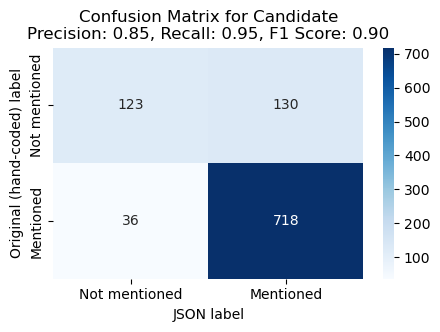

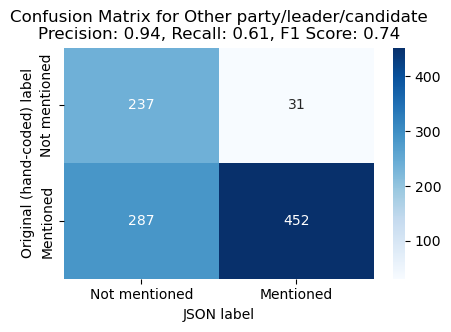

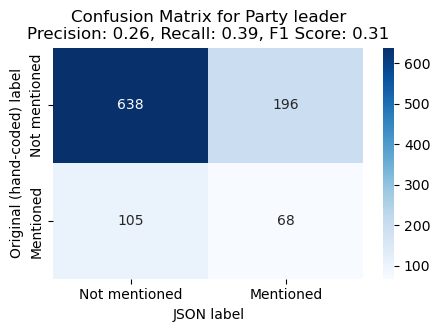

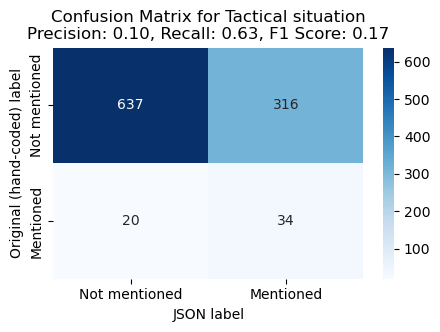

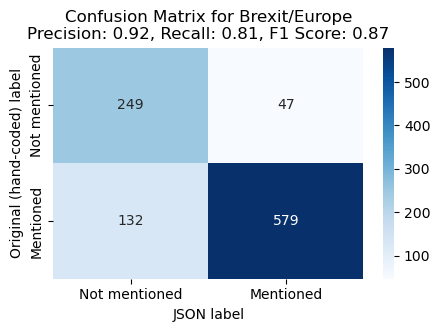

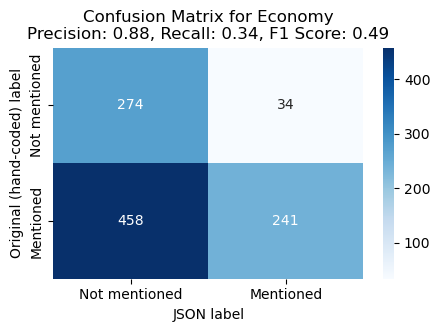

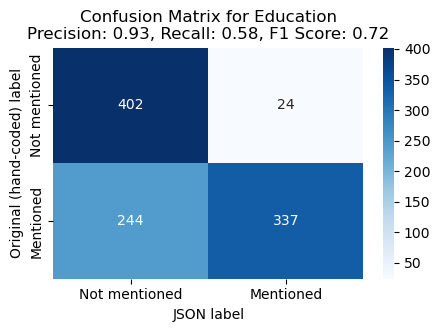

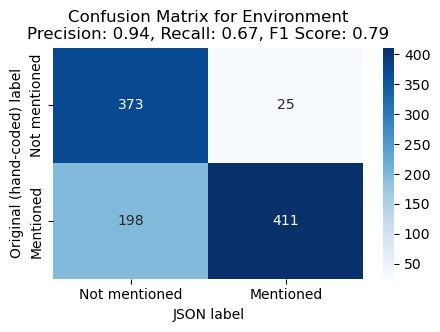

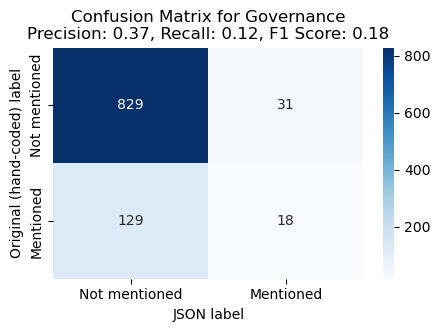

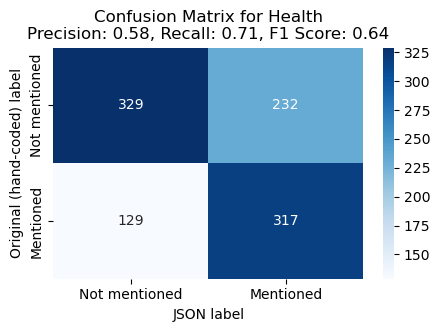

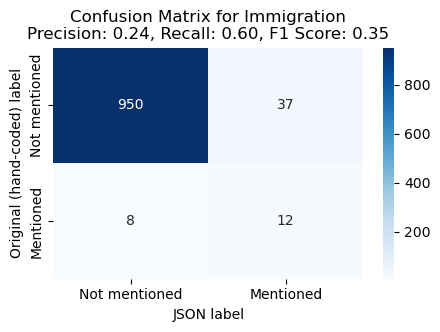

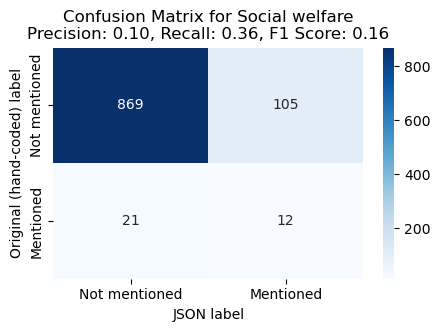

In [6]:
import pandas as pd
import json
import os
from sklearn.metrics import cohen_kappa_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_file_path = 'leaflets_data_2019.csv'
json_files_dir = 'leaflet_jsons_2017_2019'

df = pd.read_csv(csv_file_path)

mention_categories = ['Candidate', 'Other party/leader/candidate', 'Party leader', 'Tactical situation']
issue_categories = ['Brexit/Europe', 'Economy', 'Education', 'Environment', 'Governance', 'Health', 'Immigration', 'Social welfare']

csv_to_json_mapping = {
    'Candidate': 'candidate',
    'Other party/leader/candidate': 'otherPartyLeaderCandidate',
    'Party leader': 'partyLeader',
    'Tactical situation': 'tacticalSituation',
    'Brexit/Europe': 'brexitEurope',
    'Economy': 'economy',
    'Education': 'education',
    'Environment': 'environment',
    'Governance': 'governance',
    'Health': 'health',
    'Immigration': 'immigration',
    'Social welfare': 'socialWelfare'
}

def create_binary_vector_from_csv(row, categories):
    return [1 if category in str(row) else 0 for category in categories]

def create_binary_vector_from_json(json_data, categories, mapping):
    binary_vector = []
    for category in categories:
        json_key = mapping[category]
        value = json_data.get(json_key, "")
        binary_vector.append(1 if (isinstance(value, str) and value.strip()) or 
                             (isinstance(value, list) and value and value[0].get('content', '').strip()) 
                             else 0)
    return binary_vector

def safe_cohen_kappa_score(y1, y2):
    if np.all(y1 == y1[0]) and np.all(y2 == y2[0]) or np.all(y1 == y2):
        return np.nan
    else:
        try:
            return cohen_kappa_score(y1, y2)
        except:
            return np.nan

# def plot_confusion_matrix(cm, classes, title, category):
#     plt.figure(figsize=(5, 3))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
#     plt.title(title)
#     plt.ylabel('Original (hand-coded) label')
#     plt.xlabel('JSON label')
#     plt.savefig('confusion_matrices/'+category.replace(" ","_").replace("/","_").replace(",","_")+'_confusion_matrix.png',bbox_inches='tight')

def plot_confusion_matrix(cm, classes, title, category):
 # Extracting true negatives, false positives, false negatives, and true positives
    TN, FP, FN, TP = cm.ravel()
    
    # Calculating precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * (precision * recall) / (precision + recall)
        
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"{title}\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    plt.ylabel('Original (hand-coded) label')
    plt.xlabel('JSON label')
    plt.savefig('confusion_matrices/'+category.replace(" ","_").replace("/","_").replace(",","_")+'_confusion_matrix.png',bbox_inches='tight')

# Function to compute the confusion matrix for each category
def compute_confusion_matrices(csv_dataframe, json_dir, categories, mapping, category_type):
    confusion_matrices = {}

    for category in categories:
        true_labels = []
        predicted_labels = []

        for _, row in csv_dataframe.iterrows():
            leaflet_id = str(row['leaflet_ID'])
            json_path = os.path.join(json_dir, f"{leaflet_id}.json")

            if os.path.exists(json_path):
                with open(json_path, 'r') as json_file:
                    json_data = json.load(json_file)
                    json_leaflet_data = json_data.get('leaflet', {})
                    json_vector = create_binary_vector_from_json(json_leaflet_data.get(category_type, {}), [category], mapping)

                csv_vector = create_binary_vector_from_csv(row, [category])
                
                true_labels.extend(csv_vector)
                predicted_labels.extend(json_vector)

        cm = confusion_matrix(true_labels, predicted_labels)
        confusion_matrices[category] = cm
        plot_confusion_matrix(cm, ['Not mentioned', 'Mentioned'], f"Confusion Matrix for {category}", category)

    return confusion_matrices

# Calculate and plot confusion matrices for each 'Mention' category
mention_confusion_matrices = compute_confusion_matrices(df, json_files_dir, mention_categories, csv_to_json_mapping, 'mentions')

# Calculate and plot confusion matrices for each 'Issue' category
issue_confusion_matrices = compute_confusion_matrices(df, json_files_dir, issue_categories, csv_to_json_mapping, 'issues')


In [18]:
import pandas as pd
import json
import os

csv_file_path = 'leaflets_data_2019.csv'
json_files_dir = 'leaflet_jsons_2017_2019'
output_csv_path = 'processed_leaflets_data.csv'

df = pd.read_csv(csv_file_path)

mention_categories = ['Candidate', 'Other party/leader/candidate', 'Party leader', 'Tactical situation']
issue_categories = ['Brexit/Europe', 'Economy', 'Education', 'Environment', 'Governance', 'Health', 'Immigration', 'Social welfare']

csv_to_json_mapping = {
    'Candidate': 'candidate',
    'Other party/leader/candidate': 'otherPartyLeaderCandidate',
    'Party leader': 'partyLeader',
    'Tactical situation': 'tacticalSituation',
    'Brexit/Europe': 'brexitEurope',
    'Economy': 'economy',
    'Education': 'education',
    'Environment': 'environment',
    'Governance': 'governance',
    'Health': 'health',
    'Immigration': 'immigration',
    'Social welfare': 'socialWelfare'
}

def binary_from_mention_or_issue(json_data, categories, mapping):
    binary_vector = []
    for category in categories:
        json_key = mapping[category]
        value = json_data.get(json_key, "")
        binary_vector.append(1 if (isinstance(value, str) and value.strip()) or 
                             (isinstance(value, list) and value and value[0].get('content', '').strip()) 
                             else 0)
    return binary_vector

def count_key_policies(json_data):
    return len(json_data.get('keyPolicies', []))

def yimby_nimby_status(json_data):
    community = json_data.get('issues', {}).get('community', [])
    if community:
        yimby_nimby = community[0].get('yimbyNimby', '').strip().lower()
        if yimby_nimby == 'yimby':
            return 'YIMBY'
        elif yimby_nimby == 'nimby':
            return 'NIMBY'
    return 'OTHER'

def count_statements(json_data, statement_type):
    analysis = json_data.get('analysis', {}).get('statementAnalysis', {}).get(statement_type, {})
    return analysis.get('count', 0)

def count_photos(json_data, photo_type):
    return json_data.get('analysis', {}).get('photoAnalysis', {}).get(photo_type, 0)

def count_issues_focus(json_data, focus_type):
    return json_data.get('analysis', {}).get('issueFocus', {}).get(focus_type, {}).get('count', 0)

def count_endorsements(json_data):
    return len(json_data.get('endorsements', []))

def count_negative_messages(json_data, message_type):
    return json_data.get('analysis', {}).get('negativeMessaging', {}).get(message_type, {}).get('count', 0)

def is_local_candidate(json_data):
    return int(json_data.get('analysis', {}).get('localCandidate', {}).get('isLocal', False))

def process_json_files(csv_dataframe, json_dir, mention_categories, issue_categories, mapping):
    processed_data = []

    for _, row in csv_dataframe.iterrows():
        leaflet_id = str(row['leaflet_ID'])
        json_path = os.path.join(json_dir, f"{leaflet_id}.json")

        if os.path.exists(json_path):
            with open(json_path, 'r') as json_file:
                json_data = json.load(json_file)
                json_leaflet_data = json_data.get('leaflet', {})

                json_mentions_vector = binary_from_mention_or_issue(json_leaflet_data.get('mentions', {}), mention_categories, mapping)
                json_issues_vector = binary_from_mention_or_issue(json_leaflet_data.get('issues', {}), issue_categories, mapping)

                num_key_policies = count_key_policies(json_leaflet_data)
                yimby_nimby = yimby_nimby_status(json_leaflet_data)
                num_quantitative_statements = count_statements(json_leaflet_data, 'quantitative')
                num_qualitative_statements = count_statements(json_leaflet_data, 'qualitative')
                num_local_issues = count_issues_focus(json_leaflet_data, 'local')
                num_national_issues = count_issues_focus(json_leaflet_data, 'national')
                num_endorsements = count_endorsements(json_leaflet_data)

                negative_local_issues = count_negative_messages(json_leaflet_data, 'localIssues')
                negative_national_issues = count_negative_messages(json_leaflet_data, 'nationalIssues')
                negative_leader_of_opponents_party = count_negative_messages(json_leaflet_data, 'leaderOfOpponentsParty')
                negative_opposite_candidate_no_name = count_negative_messages(json_leaflet_data, 'oppositeCandidateNoName')
                negative_opposite_candidate_with_name = count_negative_messages(json_leaflet_data, 'oppositeCandidateWithName')

                is_local = is_local_candidate(json_leaflet_data)

                processed_row = {
                    'leaflet_ID': leaflet_id,
                    'Party': row['Party:'],
                    'Constituency': row['Constituency:'],
                    **{f"mention_{cat}": val for cat, val in zip(mention_categories, json_mentions_vector)},
                    **{f"issue_{cat}": val for cat, val in zip(issue_categories, json_issues_vector)},
                    'num_key_policies': num_key_policies,
                    'yimby_nimby': yimby_nimby,
                    'num_quantitative_statements': num_quantitative_statements,
                    'num_qualitative_statements': num_qualitative_statements,
                    'num_local_issues': num_local_issues,
                    'num_national_issues': num_national_issues,
                    'num_endorsements': num_endorsements,
                    'negative_local_issues': negative_local_issues,
                    'negative_national_issues': negative_national_issues,
                    'negative_leader_of_opponents_party': negative_leader_of_opponents_party,
                    'negative_opposite_candidate_no_name': negative_opposite_candidate_no_name,
                    'negative_opposite_candidate_with_name': negative_opposite_candidate_with_name,
                    'is_local': is_local
                }

                processed_data.append(processed_row)

    processed_df = pd.DataFrame(processed_data)
    return processed_df

processed_df = process_json_files(df, json_files_dir, mention_categories, issue_categories, csv_to_json_mapping)
processed_df.to_csv(output_csv_path, index=False)
print(f"Processed data saved to {output_csv_path}")


Processed data saved to processed_leaflets_data.csv
